# DESCRIPTION

In this notebook we will load the historical bid ask data, and do some basic analysis.

In [4]:
import logging
import os
import tarfile

import boto3
import numpy as np
import pandas as pd

import core.finance.resampling as cfinresa
import core.plotting.boxplot as cploboxp
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.data.client.im_raw_data_client as imvcdcimrdc
import im_v2.common.data.qa.dataset_validator as imvcdqdava
import im_v2.common.data.qa.qa_check as imvcdqqach
import im_v2.common.universe.universe as imvcounun

# Initialize the S3 client
s3 = boto3.client('s3')

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
hdbg.init_logger(verbosity=logging.INFO)
log_level = logging.INFO

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-b67bcec8-eed1-420e-b26a-73159a6de990.json'
INFO  # Git
  branch_name='CmampTask8259_Analysis_of_historical_bidask_data'
  hash='4f5c88066'
  # Last commits:
    * 4f5c88066 sonaalKant checkpoint                                                        (    5 days ago) Wed May 15 16:44:26 2024  (HEAD -> CmampTask8259_Analysis_of_historical_bidask_data, origin/CmampTask8259_Analysis_of_historical_bidask_data)
    * b97667c16 sonaalKant checkpoint                                                        (    5 days ago) Wed May 15 16:41:23 2024           
    * 9e8ed8b65 sonaalKant checkpoint                                                        (    6 days ago) Wed May 15 14:57:46 2024           
# Machine info
  system=Linux
  node name=9b9993f4b4da
  release=5.15.0-1056-aws
  version=#61~20.04.1-Ubuntu SMP Wed Mar 13 17:40:41 UTC 2024
  machine=x86_64
  processor=x86_64
  cpu 

In [39]:
def get_historical_data(currency_pair: str, date: pd.Timestamp, data_type: str = "T_DEPTH"):
    """
    Copy the tar file from S3 to local, load the tar file and return.

    :param currency_pair: symbol name for the bid_ask data eg: BTC_USDT
    :param date: download data date
    :param data_type: 'T_DEPTH' or 'S_DEPTH'
    """
    # Specify the bucket name and object key of the .tar.gz file on S3
    date_str = date.strftime('%Y-%m-%d')
    bucket_name = 'cryptokaizen-data-test'
    object_key = f'sonaal_test/binance/historical_bid_ask/{data_type}/{currency_pair}/{date_str}/data.tar.gz'
    # Specify the local directory where you want to extract the contents
    local_dir = 'temp/'
    # Create the local directory if it doesn't exist
    os.makedirs(local_dir, exist_ok=True)
    # Download the .tar.gz file from S3 to a local file
    local_file = os.path.join(local_dir, 'file.tar.gz')
    s3.download_file(bucket_name, object_key, local_file)
    # Extract the contents of the .tar.gz file
    with tarfile.open(local_file, 'r:gz') as tar:
        tar.extractall(local_dir)
    # Optionally, delete the downloaded .tar.gz file
    os.remove(local_file)
    symbol = currency_pair.replace("_","")
    if data_type == "T_DEPTH":
        snap_csv = pd.read_csv(f"temp/{symbol}_T_DEPTH_2024-04-04_depth_snap.csv")
        update_csv = pd.read_csv(f"temp/{symbol}_T_DEPTH_2024-04-04_depth_update.csv")
        return snap_csv, update_csv
    elif data_type == "S_DEPTH":
        s_depth = pd.read_csv(f"temp/{symbol}_S_DEPTH_2024-04-04.csv")
        return s_depth

In [8]:
start_timestamp = pd.Timestamp("2024-04-04T00:00:00+00:00")
end_timestamp = pd.Timestamp("2024-04-04T00:20:00+00:00")
currency_pair = "BNB_USDT"

In [9]:
snap_csv, update_csv = get_historical_data(currency_pair, start_timestamp)
snap_csv = snap_csv.rename(columns={"symbol" : "currency_pair"})
update_csv = update_csv.rename(columns={"symbol" : "currency_pair"})

## Sanity checks Snapshot CSV

In [10]:
snap_csv.head()

,currency_pair,timestamp,trans_id,first_update_id,last_update_id,side,update_type,price,qty
0,BNBUSDT,1712188765826,1712146277903521488,4339359418118,4339359418118,a,snap,575.151,0.03
1,BNBUSDT,1712188765826,1712146277903521488,4339359418118,4339359418118,a,snap,581.862,0.03
2,BNBUSDT,1712188765826,1712146277903521488,4339359418118,4339359418118,a,snap,588.573,0.03
3,BNBUSDT,1712188765826,1712146277903521488,4339359418118,4339359418118,a,snap,589.780,0.05
4,BNBUSDT,1712188765826,1712146277903521488,4339359418118,4339359418118,a,snap,593.480,0.18


In [11]:
# max of ask price < min of bid price
snap_csv[snap_csv["side"] == "a"]["price"].min() > snap_csv[snap_csv["side"] == "b"]["price"].max()

True

In [12]:
sorted(snap_csv[snap_csv["side"] == "a"]["price"])[:20]

[562.1,
 562.11,
 562.12,
 562.13,
 562.14,
 562.15,
 562.16,
 562.17,
 562.18,
 562.19,
 562.2,
 562.21,
 562.22,
 562.23,
 562.24,
 562.25,
 562.26,
 562.27,
 562.28,
 562.29]

In [13]:
sorted(snap_csv[snap_csv["side"] == "b"]["price"])[::-1][:20]

[562.09,
 562.08,
 562.07,
 562.06,
 562.05,
 562.04,
 562.03,
 562.02,
 562.01,
 562.0,
 561.99,
 561.98,
 561.97,
 561.96,
 561.95,
 561.94,
 561.93,
 561.92,
 561.91,
 561.9]

In [14]:
bids_snap = snap_csv[snap_csv['side'] == 'b'].groupby('price')['qty'].sum().sort_index(ascending=False)
ask_snap = snap_csv[snap_csv['side'] == 'a'].groupby('price')['qty'].sum().sort_index()

In [15]:
bids_snap

price
562.090        41.60
562.080         8.82
562.070         9.49
562.060         8.65
562.050         5.23
             ...    
0.005      100050.00
0.004      375050.00
0.003      100050.00
0.002      200050.00
0.001      203106.27
Name: qty, Length: 20374, dtype: float64

In [16]:
ask_snap

price
562.10      12.02
562.11       0.05
562.12       2.17
562.13      11.57
562.14      10.84
            ...  
58800.60     0.10
61800.60     0.10
64800.60     0.10
67800.60     0.10
70800.60     0.08
Name: qty, Length: 16540, dtype: float64

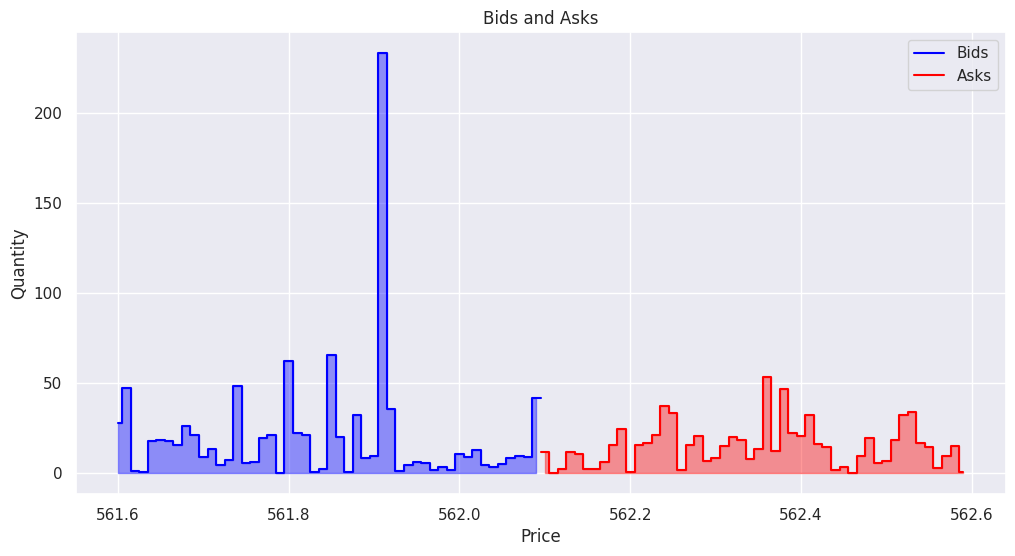

In [49]:
cploboxp.plot_bid_ask_price_levels(bids_snap, ask_snap)

In [19]:
snap_csv["trans_id"].value_counts()

trans_id
1712146277903521488    21795
1712154385668255484       33
1712188759597141007       19
1712185207493183258       18
1712181614022411399       17
                       ...  
1712177186415903470        1
1712177199737227430        1
1712177202503654730        1
1712177209453337176        1
1712177129404310103        1
Name: count, Length: 14644, dtype: int64

In [20]:
snap_csv["price"].value_counts()

price
564.050    1
575.151    1
581.862    1
588.573    1
589.780    1
          ..
594.810    1
594.870    1
594.890    1
595.010    1
595.030    1
Name: count, Length: 36914, dtype: int64

In [21]:
snap_csv[["price", "qty"]].describe()

,price,qty
count,36914.000000,36914.000000
mean,561.395125,46.178959
std,1085.458072,2973.784195
min,0.001000,0.010000
25%,418.602500,0.040000
50%,542.235000,0.130000
75%,641.337500,0.640000
max,70800.600000,375050.000000


## Sanity Checks Update CSV

In [50]:
update_csv.head()

,currency_pair,timestamp,trans_id,first_update_id,last_update_id,side,update_type,price,qty
0,BNBUSDT,1712188765842,1712188765842937155,4339359418584,4339359418584,a,set,563.88,17.49
1,BNBUSDT,1712188765842,1712188765842937155,4339359418584,4339359418584,a,set,564.04,43.26
2,BNBUSDT,1712188765885,1712188765885433835,4339359419908,4339359419908,b,set,561.80,62.30
3,BNBUSDT,1712188765885,1712188765885801968,4339359419918,4339359419918,b,set,561.80,62.38
4,BNBUSDT,1712188765895,1712188765895661954,4339359420161,4339359420161,b,set,25.00,0.20


In [51]:
update_csv["update_type"].value_counts()

update_type
set    33116001
Name: count, dtype: int64

In [52]:
update_csv[["price", "qty"]].describe()

,price,qty
count,3.311600e+07,3.311600e+07
mean,5.597827e+02,1.791265e+01
std,1.151970e+02,5.189023e+01
min,6.610000e+00,0.000000e+00
25%,5.774900e+02,2.050000e+00
50%,5.836700e+02,8.290000e+00
75%,5.888800e+02,1.936000e+01
max,6.745000e+04,6.099430e+03


## QA Check

Perform basic QA to check:
1. Gaps in data
2. NaN values in data

In [53]:

qa_check_list = [
    imvcdqqach.GapsInTimeIntervalBySymbolsCheck(
        start_timestamp, end_timestamp, "1T", align=True
    ),
    imvcdqqach.NaNChecks(),
]
dataset_validator = imvcdqdava.DataFrameDatasetValidator(qa_check_list)

In [26]:
try:
    dataset_validator.run_all_checks([update_csv])
except Exception as e:
    # Pass information about success or failure of the QA
    #  back to the task that invoked it.
    data_qa_outcome = str(e)
    raise e

INFO  Running all QA checks:
INFO  	GapsInTimeIntervalBySymbolsCheck: PASSED
INFO  	NaNChecks: PASSED
